# Identifying Burglary Crime Hotspots in London Using POI Data and Spatial Machine Learning

## Preparation

- [Github link](https://github.com/ixxiiris/CASA0006_assessment) 

- Number of words: ***

- Runtime: *** hours (*Memory 10 GB, CPU Intel i7-10700 CPU @2.90GHz*)

- Coding environment: SDS Docker (or anything else)

- License: this notebook is made available under the [Creative Commons Attribution license](https://creativecommons.org/licenses/by/4.0/) (or other license that you like).

- Additional library *[libraries not included in SDS Docker or not used in this module]*:
    - **watermark**: A Jupyter Notebook extension for printing timestamps, version numbers, and hardware information.
    - ......

## Table of contents

1. [Introduction](#Introduction)

1. [Research questions](#Research-questions)

1. [Data](#Data)

1. [Methodology](#Methodology)

1. [库准备，英文待查找]

1. [Data Preprocessing](#data-preprocessing)

1. [Data Analysis](#data-analysis)

1. [Results and discussion](#Results-and-discussion)

1. [Conclusion](#Conclusion)

1. [References](#References)

## Introduction

[[ go back to the top ]](#Table-of-contents)

Burglary crimes in urban environments are known to be non-randomly distributed and tend to cluster around specific urban features. Studies have shown that the spatial layout and land use, including the presence of Points of Interest (POIs) such as shopping areas, transport hubs and recreational facilities, are significantly associated with higher crime rates (Brantingham & Brantingham, 1995; Povala et al., 2020).

This project explores the spatial relationship between burglary crime and POI distribution in London, applying interpretable machine learning techniques and spatial analyses to identify the urban features most associated with burglary hotspots. The findings can provide actionable insights for urban design and targeted policing.


## Research questions

[[ go back to the top ]](#Table-of-contents)

- Which types of Points of Interest (POIs) are most associated with burglary hotspots in London?

- How can machine learning methods be leveraged to analyse their spatial influence on crime distribution?


## Data

[[ go back to the top ]](#Table-of-contents)

| Variable                   | Type       | Description                                                            | Notes                                  |
|----------------------------|------------|------------------------------------------------------------------------|----------------------------------------|
| Burglary crime count       | Numeric    | Monthly burglary offence counts at LSOA level                         | Original data (London Data Store)      |
| Burglary crime rate        | Numeric    | Interpolated burglary rate per 200m × 200m grid cell                  | Derived via IDW/Kriging interpolation  |
| ATM count                  | Numeric    | Number of ATMs within each grid cell                                  | Derived from OSM POI                   |
| Restaurant count           | Numeric    | Number of restaurants within each grid cell                           | Derived from OSM POI                   |
| Shop count                 | Numeric    | Number of shops or retail units within each grid cell                 | Derived from OSM POI                   |
| Pub count                  | Numeric    | Number of pubs within each grid cell                                  | Derived from OSM POI                   |
| Bus stop count             | Numeric    | Number of bus stops within each grid cell                             | Derived from OSM POI                   |
| Park area                  | Numeric    | Total park area (in m²) within each grid cell                         | Derived from OSM polygon data          |
| Distance to train station  | Numeric    | Distance from grid centroid to the nearest train station (in meters) | Calculated using spatial nearest-neighbour |
| Grid centroid longitude    | Numeric    | Longitude of grid cell centroid                                       | Derived from grid geometry             |
| Grid centroid latitude     | Numeric    | Latitude of grid cell centroid                                        | Derived from grid geometry             |


## Methodology

[[ go back to the top ]](#Table-of-contents)

*[Note: a flow chart that describes the methodology is strongly encouraged - see the example below. This flow chart can be made using Microsoft powerpoint or visio or other software]*

Source: see [link](https://linkinghub.elsevier.com/retrieve/pii/S2210670722004437).

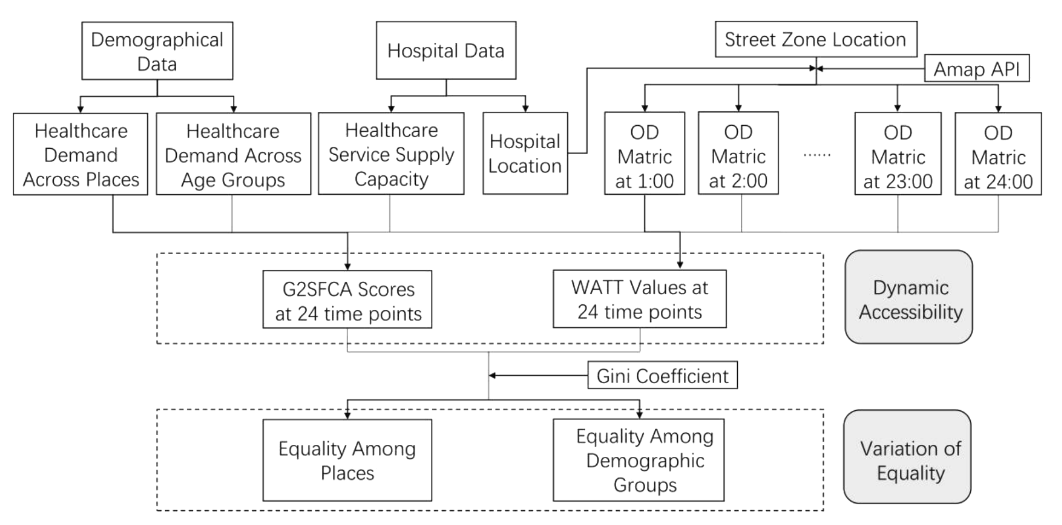

## Importing Packages
[[ go back to the top ]](#Table-of-contents)

文字待补充，需要简述库作用

In [41]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy.spatial import cKDTree

## Data Preprocessing
[[ go back to the top ]](#Table-of-contents)

### Study Area and Spatial Resolution

The official Greater London administrative boundary provided by the Greater London Authority (GLA) defines the study area. For finer spatial analysis, the study generated a homogeneous grid with a spatial resolution of 200m × 200m, which was cropped to this boundary. This gridded process ensures spatial consistency and supports spatial interpolation and element aggregation on a city-wide scale.

In [ ]:
# Load GLA administrative boundary shapefile
gla_boundary = gpd.read_file("data/London_boundary/London_GLA_Boundary.shp")
gla_boundary = gla_boundary.to_crs(epsg=27700)

In [ ]:
# Create 200m × 200m grid function
def create_grid_over_boundary(boundary_gdf, grid_size=200):
    # Get the full bounding box of the input boundary
    xmin, ymin, xmax, ymax = boundary_gdf.total_bounds

    # Create grid cells at the specified resolution
    cols = np.arange(xmin, xmax, grid_size)
    rows = np.arange(ymin, ymax, grid_size)
    
    grid_cells = []
    for x in cols:
        for y in rows:
            grid_cells.append(box(x, y, x + grid_size, y + grid_size))
    
    # Build GeoDataFrame from grid cells
    grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs=boundary_gdf.crs)
    
    # Clip grid to the official boundary
    grid_clipped = gpd.overlay(grid, boundary_gdf, how='intersection')
    
    return grid_clipped

In [ ]:
# Generate the clipped grid
grid_200m = create_grid_over_boundary(gla_boundary, grid_size=200)
print(f"Total number of grid cells within London: {len(grid_200m)}")

Total number of grid cells within London: 40626


C:\Users\10851\AppData\Local\Temp\ipykernel_9644\2594996672.py:19: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  grid_clipped = gpd.overlay(grid, boundary_gdf, how='intersection')


A total of 40626 grid cells are generated, covering all densely populated and associated areas of London. Grid cells that lie outside the London boundary or do not contain any data are excluded.

C:\Users\10851\AppData\Local\Temp\ipykernel_9644\4095166431.py:7: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
C:\Users\10851\AppData\Local\Temp\ipykernel_9644\4095166431.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


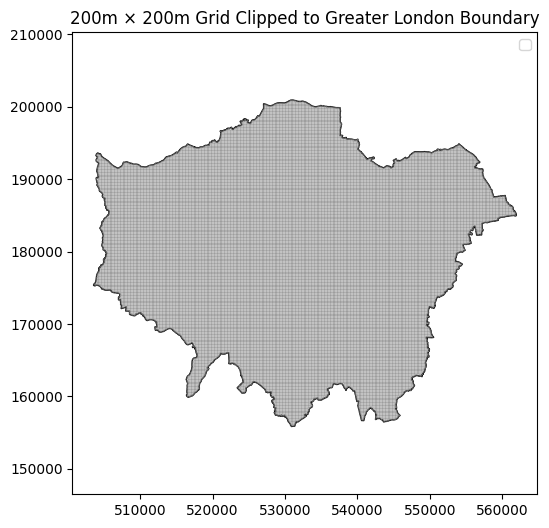

In [ ]:
# Visual check: Grid overlaid on official boundary
fig, ax = plt.subplots(figsize=(6, 6))
gla_boundary.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1, label="GLA Boundary")
grid_200m.plot(ax=ax, facecolor="none", edgecolor="grey", linewidth=0.2, label="200m Grid")
plt.title("200m × 200m Grid Clipped to Greater London Boundary")
plt.axis('equal')
plt.legend()
plt.show()

In [26]:
# save grid file
grid_200m.to_file("data/London_boundary/Grid_200m_London.geojson", driver="GeoJSON")

### Crime Data Preparation


#### Burglary Data Selection and Aggregation

Burglary data from the Metropolitan Police Service (MPS) was used as a target variable. Burglary comprises two types of burglary based on the existing categories of minor offences:
- **Burglary in a Dwelling** (residential burglary)
- **Burglary Business and Community** (non-residential burglary)

Monthly crime data from **January to December 2019** were extracted and aggregated at the Lower Super Output Area (LSOA) level to calculate annual crime numbers. The year 2019 was chosen as the most recent period before the epidemic, thus avoiding data distortions caused by behavioural changes and enforcement patterns associated with the COVID-19 pandemic.

In [ ]:
# Load the historic MPS crime dataset
crime_df = pd.read_csv("data/London_crime/MPS LSOA Level Crime (Historical).csv")

# Display the first few rows and column names for structure verification
print("Column names:", crime_df.columns)
crime_df.head()

Column names: Index(['LSOA Code', 'LSOA Name', 'Borough', 'Major Category', 'Minor Category',
       '201903', '201904', '201905', '201906', '201907',
       ...
       '202206', '202207', '202208', '202209', '202210', '202211', '202212',
       '202301', '202302', '202303'],
      dtype='object', length=161)


,LSOA Code,LSOA Name,Borough,Major Category,Minor Category,201903,201904,201905,201906,201907,...,202206,202207,202208,202209,202210,202211,202212,202301,202302,202303
0,E01000006,Barking and Dagenham 016A,E09000002,ARSON AND CRIMINAL DAMAGE,ARSON,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,E01000006,Barking and Dagenham 016A,E09000002,ARSON AND CRIMINAL DAMAGE,CRIMINAL DAMAGE,1,2,0,1,0,...,0,2,1,0,0,0,0,0,0,1
2,E01000006,Barking and Dagenham 016A,E09000002,BURGLARY,BURGLARY BUSINESS AND COMMUNITY,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,E01000006,Barking and Dagenham 016A,E09000002,BURGLARY,BURGLARY IN A DWELLING,1,0,3,1,0,...,0,0,0,0,0,2,0,0,0,0
4,E01000006,Barking and Dagenham 016A,E09000002,DRUG OFFENCES,POSSESSION OF DRUGS,2,2,0,0,0,...,0,0,1,0,4,1,0,0,0,0


In [21]:
# Define burglary categories based on actual values in the dataset
target_minor = ['BURGLARY BUSINESS AND COMMUNITY', 'BURGLARY IN A DWELLING']

# Filter to keep only those rows matching burglary categories
crime_burglary = crime_df[
    (crime_df["Major Category"] == "BURGLARY") &
    (crime_df["Minor Category"].isin(target_minor))
]

In [22]:
# Define list of column names corresponding to each month in 2019
months_2019 = [f"2019{str(m).zfill(2)}" for m in range(1, 13)]

# Ensure all required columns exist
assert all(col in crime_burglary.columns for col in months_2019), "Some 2019 columns missing"

# Sum across all 2019 months to obtain total burglary counts
crime_burglary["burglary_total_2019"] = crime_burglary[months_2019].sum(axis=1)

C:\Users\10851\AppData\Local\Temp\ipykernel_9644\138123521.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_burglary["burglary_total_2019"] = crime_burglary[months_2019].sum(axis=1)


In [23]:
# Group by LSOA and sum across both residential + business categories
burglary_lsoa = (
    crime_burglary
    .groupby("LSOA Code")["burglary_total_2019"]
    .sum()
    .reset_index()
    .rename(columns={"LSOA Code": "LSOA_code"})
)

# Check output
print(f"Number of LSOAs with burglary data: {len(burglary_lsoa)}")
burglary_lsoa.head()

Number of LSOAs with burglary data: 4988


,LSOA_code,burglary_total_2019
0,E01000006,13
1,E01000007,20
2,E01000008,17
3,E01000009,14
4,E01000011,4


#### Spatial Interpolation to Grid Resolution
Aggregated burglary data at the LSOA level were converted to a continuous surface using inverse distance weighted (IDW) interpolation. The centre of mass of each LSOA polygon was used as a known input point and burglary values were estimated at the centre of mass of each 200 m × 200 m grid cell.

In [24]:
# Load LSOA shapefile and convert to British National Grid
lsoa_gdf = gpd.read_file("data/London_LSOA_2011/LSOA_2011_London_gen_MHW.shp")
lsoa_gdf = lsoa_gdf.to_crs(epsg=27700)

# Merge burglary totals into LSOA GeoDataFrame
lsoa_gdf = lsoa_gdf.merge(burglary_lsoa, how="left", left_on="LSOA11CD", right_on="LSOA_code")

# Drop rows without burglary data (optional)
lsoa_gdf = lsoa_gdf.dropna(subset=["burglary_total_2019"])

In [25]:
# Use centroids of LSOAs as interpolation points
lsoa_points = lsoa_gdf.copy()
lsoa_points["geometry"] = lsoa_points.centroid

In [ ]:
# Prepare grid centroids for interpolation targets
# Load the 200m grid you previously created
grid = gpd.read_file("data/London_boundary/Grid_200m_London.geojson")

# Compute centroids of each grid cell (for interpolation)
grid["centroid"] = grid.centroid
grid_points = pd.DataFrame({
    "x": grid["centroid"].x,
    "y": grid["centroid"].y
})

In [33]:
# Perform IDW interpolation
def idw_interpolation(xy_known, values_known, xy_targets, k=8, power=2):
    tree = cKDTree(xy_known)
    dists, idxs = tree.query(xy_targets, k=k)
    
    # Avoid division by zero
    dists = np.where(dists == 0, 1e-10, dists)
    weights = 1 / dists ** power
    
    values = np.sum(weights * values_known[idxs], axis=1) / np.sum(weights, axis=1)
    return values

In [ ]:
# Prepare coordinates and values for IDW
xy_known = np.array(list(zip(lsoa_points.geometry.x, lsoa_points.geometry.y)))
values_known = lsoa_points["burglary_total_2019"].values
xy_targets = np.array(list(zip(grid_points["x"], grid_points["y"])))

# Run IDW interpolation
grid["burglary_idw_2019"] = idw_interpolation(xy_known, values_known, xy_targets)

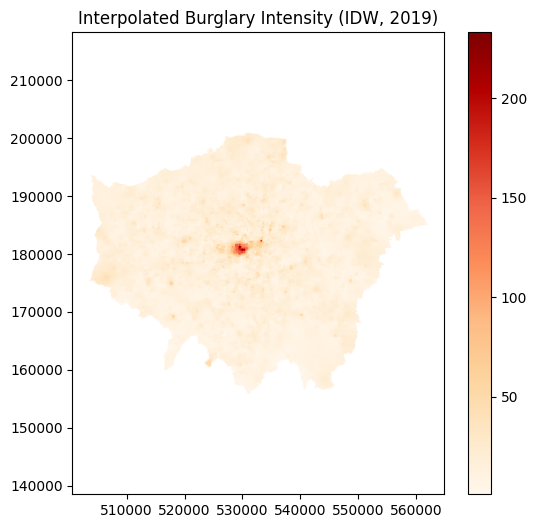

In [ ]:
# Visual check: IDW result
fig, ax = plt.subplots(figsize=(6, 6))
grid.plot(column="burglary_idw_2019", ax=ax, cmap="OrRd", legend=True, edgecolor="none")
plt.title("Interpolated Burglary Intensity (IDW, 2019)")
plt.axis('equal')
plt.show()

#### Standardisation of Burglary Density
To achieve spatial comparability and to support predictive modelling, the study normalised the interpolated values to derive the burglary density per square kilometre. This was done by dividing each grid-level burglary estimate by the grid area (0.04 km² ), resulting in an outcome variable expressed as the number of events per square kilometre.

In [36]:
# Standardisation: calculation of burglary density per square kilometre
grid["burglary_density_per_km2"] = grid["burglary_idw_2019"] / 0.04

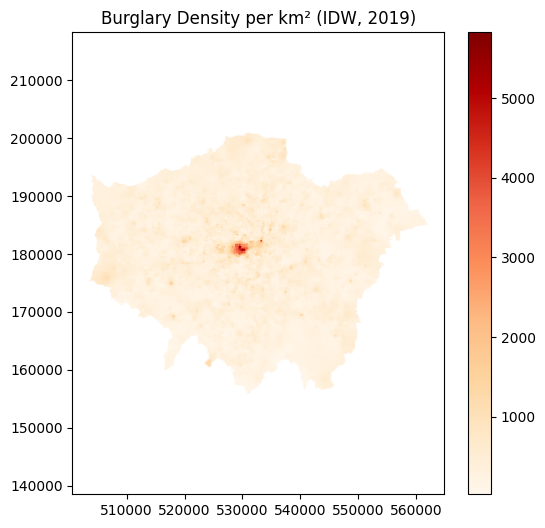

In [ ]:
# Visual check: Standardisation result
fig, ax = plt.subplots(figsize=(6, 6))
grid.plot(
    column="burglary_density_per_km2",
    ax=ax,
    cmap="OrRd",
    legend=True,
    edgecolor="none"
)
plt.title("Burglary Density per km² (IDW, 2019)")
plt.axis('equal')
plt.show()

This spatial normalisation technique is well established in environmental criminology to support micro-risk mapping and has been validated in previous studies (e.g. Bediroglu & Colak, 2024; Povala et al, 2020; Wheeler & Steenbeek, 2021)

### POI Data Extraction and Cleaning

Point of Interest (POI) data was extracted from OpenStreetMap using the OSMnx Python library. The selected POI categories are based on everyday activity theory and crime pattern theory, which emphasise the role of everyday travel infrastructure, social activity centres and target-rich environments in shaping opportunities for crime (Brantingham & Brantingham, 1995; Groff & McCord, 2012; Wheeler & Steenbeek, 2021).

The following categories were included based on their empirical and theoretical associations with burglary and spatial crime risk:

- **ATMs** – represent financial access points and potential crime attractors.  
- **Restaurants and pubs** – serve as social and leisure hubs with extended activity hours.  
- **Shops** – include high-footfall retail locations with valuable goods.  
- **Parks** – offer open spaces that may function as crime generators under certain conditions.  
- **Bus stops** – reflect routine movement infrastructure and increase offender awareness spaces.

The POI data underwent standardised cleaning procedures to ensure spatial accuracy and analytical compatibility:

- **Deduplication**: removing duplicate records and geometries  
- **Coordinate system alignment**: converting all geometries to British National Grid (EPSG:27700)  
- **Spatial clipping**: limiting POI features to the Greater London boundary

These cleaned and categorised POIs are later aggregated to the 200 m × 200 m grid cells to serve as explanatory variables in the crime prediction model.


In [ ]:
# Load the Greater London boundary and ensure correct coordinate system (British National Grid)
gla_boundary = gpd.read_file("data/London_boundary/London_GLA_Boundary.shp")
gla_boundary = gla_boundary.to_crs(epsg=27700)

# Define POI categories of interest based on OSM tags
poi_tags = {
    'atm': {'amenity': 'atm'},
    'restaurant': {'amenity': 'restaurant'},
    'pub': {'amenity': 'pub'},
    'shop': {'shop': True},  # Includes all types of shops
    'park': {'leisure': 'park'},
    'bus_stop': {'highway': 'bus_stop'}
}

# Download, clean and clip POI data for each category
poi_layers = []

for label, tags in poi_tags.items():
    # Reproject boundary to WGS84 for querying OpenStreetMap
    gla_polygon = gla_boundary.to_crs(epsg=4326).unary_union

    # Download POIs within the GLA boundary from OpenStreetMap
    pois = ox.features_from_polygon(gla_polygon, tags)

    # Retain only valid geometries
    pois = pois[pois.geometry.notnull()]

    # Reproject POIs back to British National Grid
    pois = pois.to_crs(epsg=27700)
    
    # Keep only the geometry and assign category label
    pois = pois[["geometry"]].copy()
    pois["category"] = label
    
    # Remove any duplicate geometries (e.g. overlapping features)
    pois = pois.drop_duplicates(subset=["geometry"])
    
    # Clip POIs to the official London boundary
    pois = gpd.overlay(pois, gla_boundary, how="intersection")
    
    poi_layers.append(pois)

# Combine all POI categories into a single GeoDataFrame
poi_all = gpd.GeoDataFrame(pd.concat(poi_layers, ignore_index=True), crs="EPSG:27700")

# Display the number of POIs per category for verification
print(poi_all["category"].value_counts())

C:\Users\10851\AppData\Local\Temp\ipykernel_9644\4090745776.py:20: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gla_polygon = gla_boundary.to_crs(epsg=4326).unary_union
C:\Users\10851\AppData\Local\Temp\ipykernel_9644\4090745776.py:20: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gla_polygon = gla_boundary.to_crs(epsg=4326).unary_union


## Data Analysis
[[ go back to the top ]](#Table-of-contents)

## Results and discussion

[[ go back to the top ]](#Table-of-contents)

## Conclusion

[[ go back to the top ]](#Table-of-contents)

## References

[[ go back to the top ]](#Table-of-contents)

- Brantingham, P. L., & Brantingham, P. J. (1995). *Criminality of place: Crime generators and crime attractors*. European Journal on Criminal Policy and Research, 3(3), 5–26.
- Bernasco, W., & Block, R. (2011). *Robberies in Chicago: A block-level analysis of the influence of crime generators and attractors*. Journal of Research in Crime and Delinquency, 48(1), 33–57.
- Groff, E. R., & McCord, E. S. (2012). *The role of neighborhood parks as crime generators*. Security Journal, 25(1), 1–24.
- Povala, J., Virtanen, S., & Girolami, M. (2020). *Burglary in London: Insights from statistical heterogeneous spatial point processes*. Journal of the Royal Statistical Society: Series C.
- Zhang, X., Liu, L., & Xiao, L. (2022). *Interpretable machine learning models for crime prediction*. Cities, 122, 103547.